<a href="https://colab.research.google.com/github/sokrypton/GREMLIN_CPP/blob/master/GREMLIN_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GREMLIN_TF v2
GREMLIN implemented in tensorflow

### Change log:

*   Jan. 15, 2018
  - LBFGS optimizer replaced with a modified version of the ADAM optimizer, which runs 20-50x faster on GPUs.
  - Added option for stochastic gradient descent (via batch_size)
  
### Method:
GREMLIN takes a multiple sequence alignment (MSA) and returns a Markov Random Field (MRF or Potts model). The MRF consists of a one-body term (V) that encodes conservation, and a two-body term (W) that encodes co-evolution. V is a Lx21 matrix (21 values for each position). 21 because there are 20 amino acids + gap. W is a Lx21xLx21 (21x21 values for each pair of positions), the matrix is symmetric. Where L is the (L)ength.

For more details about the method see:
[Google slides](https://docs.google.com/presentation/d/1aooxoksosSv7CWs9-ktqhUjyXR3wrgbG5a6PCr92od4/) and [Google colab](https://colab.research.google.com/drive/17RJcExuyifnd7ShTcsZGh6mBpWq0-s60)


In [0]:
# ------------------------------------------------------------
# "THE BEERWARE LICENSE" (Revision 42):
# <so@g.harvard.edu> and <pkk382@g.harvard.edu> wrote this code.
# As long as you retain this notice, you can do whatever you want
# with this stuff. If we meet someday, and you think this stuff
# is worth it, you can buy us a beer in return.
# --Sergey Ovchinnikov and Peter Koo
# ------------------------------------------------------------
#
# if you use this code, please cite the following papers:
#
# Balakrishnan, Sivaraman, Hetunandan Kamisetty, Jaime G. Carbonell,
# Su‐In Lee, and Christopher James Langmead.
# "Learning generative models for protein fold families."
# Proteins: Structure, Function, and Bioinformatics 79, no. 4 (2011): 1061-1078.
#
# Kamisetty, Hetunandan, Sergey Ovchinnikov, and David Baker.
# "Assessing the utility of coevolution-based residue–residue
# contact predictions in a sequence-and structure-rich era."
# Proceedings of the National Academy of Sciences (2013): 201314045.

## libraries

In [0]:
# IMPORTANT, only tested using PYTHON 3!
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
from scipy import stats
from scipy.spatial.distance import pdist,squareform
import pandas as pd

## Params

In [0]:
################
# note: if you are modifying the alphabet
# make sure last character is "-" (gap)
################
alphabet = "ARNDCQEGHILKMFPSTWYV-"
states = len(alphabet)
a2n = {}
for a,n in zip(alphabet,range(states)):
  a2n[a] = n
################

def aa2num(aa):
  '''convert aa into num'''
  if aa in a2n: return a2n[aa]
  else: return a2n['-']

## Functions for working with MSA

In [0]:
# from fasta
def parse_fasta(filename,limit=-1):
  '''function to parse fasta'''
  header = []
  sequence = []
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if line[0] == ">":
      if len(header) == limit:
        break
      header.append(line[1:])
      sequence.append([])
    else:
      sequence[-1].append(line)
  lines.close()
  sequence = [''.join(seq) for seq in sequence]
  return np.array(header), np.array(sequence)
  
def mk_msa(seqs):
  '''converts list of sequences to numpy array'''
  msa = []
  for seq in seqs:
    msa.append([aa2num(aa) for aa in seq])
  return np.array(msa)

def filt_gaps(msa,gap_cutoff=0.5):
  '''filters alignment to remove gappy positions'''
  tmp = np.zeros_like(msa)
  tmp[np.where(msa == 20)] = 1
  non_gaps = np.where(np.sum(tmp.T,-1).T/msa.shape[0] < gap_cutoff)[0]
  return msa[:,non_gaps],non_gaps

def get_eff(msa,eff_cutoff=0.8):
  '''compute effective weight for each sequence'''
  ncol = msa.shape[1]
  
  # pairwise identity
  msa_sm = 1.0 - squareform(pdist(msa,"hamming"))

  # weight for each sequence
  msa_w = np.zeros_like(msa_sm)
  msa_w[np.where(msa_sm >= eff_cutoff)] = 1
  msa_w = 1/np.sum(msa_w,-1)
  
  return msa_w

## Optimizers

In [0]:
########################################################################################
# ADAM
########################################################################################
# Note: this is a modified version of adam optimizer. More specifically, we replace "vt"
# with sum(g*g) instead of (g*g). Furthmore, we find that disabling the bias correction
# (b_fix=False) speeds up convergence for our case.

def opt_adam(loss, var_list=None, lr=1.0, scope="adam", b1=0.9, b2=0.999, b_fix=False):
  if var_list is None: var_list = tf.trainable_variables()  
  with tf.variable_scope(scope):
    gradients = tf.gradients(xs=var_list,ys=loss)
    if b_fix: t = tf.Variable(1.0,"t")
    opt = []
    for n,(x,g) in enumerate(zip(var_list,gradients)):
      if g is not None:
        ini = dict(initializer=tf.zeros_initializer,trainable=False)
        mt = tf.get_variable("mt_"+str(n),shape=x.shape, **ini)
        vt = tf.get_variable("vt_"+str(n),shape=(1,), **ini)
        mt_tmp = b1*mt+(1-b1)*g
        vt_tmp = b2*vt+(1-b2)*tf.reduce_sum(tf.square(g))
        lr_tmp = lr/tf.sqrt(vt_tmp)
        
        if b_fix: lr_tmp = lr_tmp * tf.sqrt(1-tf.pow(b2,t))/(1-tf.pow(b1,t))
        
        opt.append(x.assign_add(-lr_tmp * mt_tmp))
        opt.append(vt.assign(vt_tmp))
        opt.append(mt.assign(mt_tmp))
        
    if b_fix: t.assign_add(1.0)
    return(tf.group(opt))

In [0]:
########################################################################################
# SGD
########################################################################################
# for comparison we also implement a simple gradient decent optimizer
# note: opt_sgd() == opt_adam(b1=0.0, b2=0.0, b_fix=False)
def opt_sgd(loss, var_list=None, lr=1.0):

  if var_list is None: var_list = tf.trainable_variables()  
  gradients = tf.gradients(xs=var_list,ys=loss)
  opt = []
  for x,g in zip(var_list,gradients):
    if g is not None:
      lr_tmp = lr/tf.sqrt(tf.reduce_sum(tf.square(g)))
      opt.append(x.assign_add(-lr_tmp * g))
  return(tf.group(opt))

## GREMLIN

In [0]:
def GREMLIN(msa, opt_type="adam", opt_iter=100, opt_rate=1.0, batch_size=None):  
  
  # compute effective weight for each sequence
  msa_eff = get_eff(msa,0.8)

  # compute effective number of sequences
  neff = np.sum(msa_eff)
  
  print(f"neff {neff}")

  # store shape of msa
  nrow = msa.shape[0] # num rows (sequences)
  ncol = msa.shape[1] # num cols (positions)

  ##############################################################
  # SETUP COMPUTE GRAPH
  ##############################################################
  
  # kill any existing tensorflow graph
  tf.reset_default_graph()

  # msa (multiple sequence alignment) 
  MSA = tf.placeholder(tf.int32,shape=(None,ncol),name="msa")
  
  # one-hot encode msa
  OH_MSA = tf.one_hot(MSA,states)

  # msa weight
  MSA_EFF = tf.placeholder(tf.float32, shape=(None,), name="msa_eff")

  ini_zero = tf.zeros_initializer
  
  # 1-body-term of the MRF
  V = tf.get_variable(name="V", shape=[ncol,states],dtype=tf.float32, initializer=ini_zero)
  # 2-body-term of the MRF
  W_tmp = tf.get_variable(name="W_tmp", shape=[states,states,ncol,ncol], dtype=tf.float32, initializer=ini_zero)
  
  # set diagional to zero, symmetrize and transpose to [ncol,states,ncol,states]
  W = W_tmp
  W = W - tf.matrix_band_part(W,0,0)
  W = W + tf.transpose(W,[1,0,3,2])
  W = tf.transpose(W,[2,0,3,1])
  
  def L2(x): return tf.reduce_sum(tf.square(x))
  
  ########################################
  # V
  ########################################
  def fx_V(V):
    # Note: we find optimizing V first, requires less steps for V+W convergence!
    H_V = tf.reduce_sum(tf.multiply(OH_MSA,V),axis=-1)
    Z_V = tf.reduce_logsumexp(V,axis=-1)
    VLL = tf.reduce_sum(H_V-Z_V,axis=1)
    
    L2_V = 0.01 * L2(V)
    return -tf.reduce_sum(VLL*MSA_EFF)*(neff/tf.reduce_sum(MSA_EFF)) + L2_V
    
  ########################################
  # V + W
  ########################################

  def fx_VW(V,W):
    VW = V + tf.tensordot(OH_MSA,W,2)

    # hamiltonian
    H = tf.reduce_sum(tf.multiply(OH_MSA,VW),axis=2)
    # local Z (parition function)
    Z = tf.reduce_logsumexp(VW,axis=2)

    # Psuedo-Log-Likelihood
    PLL = tf.reduce_sum(H - Z, axis=1)

    # Regularization
    L2_V = 0.01 * L2(V)
    L2_W = 0.01 * L2(W) * 0.5 * tf.constant((ncol-1)*(states-1),tf.float32)

    # loss function to minimize
    return -tf.reduce_sum(PLL*MSA_EFF)*(neff/tf.reduce_sum(MSA_EFF)) + L2_V + L2_W
  
  loss_V = fx_V(V)
  loss_VW = fx_VW(V,W)

  ##############################################################
  # MINIMIZE LOSS FUNCTION
  ##############################################################
  if opt_type == "adam":  
    opt_V = opt_adam(loss_V,var_list=[V],lr=opt_rate,scope="V")
    opt_VW = opt_adam(loss_VW,var_list=[V,W_tmp],lr=opt_rate,scope="VW")
    
  if opt_type == "sgd":  
    opt_V = opt_sgd(loss_V,var_list=[V],lr=opt_rate)
    opt_VW = opt_sgd(loss_VW,var_list=[V,W_tmp],lr=opt_rate)

    
  with tf.Session() as sess:
    # initialize variables V and W
    sess.run(tf.global_variables_initializer())

    if opt_type == "lbfgs":
      lbfgs = tf.contrib.opt.ScipyOptimizerInterface
      # optimize V
      opt = lbfgs(loss_V,method="L-BFGS-B",options={'maxiter': opt_iter},var_list=[V])
      opt.minimize(sess,{MSA:msa,MSA_EFF:msa_eff})
      
      # optimize V+W
      opt = lbfgs(loss_VW,method="L-BFGS-B",options={'maxiter': opt_iter},var_list=[V,W_tmp])
      opt.minimize(sess,{MSA:msa,MSA_EFF:msa_eff})
      
    if opt_type == "adam" or opt_type == "sgd":
      opt_list = [[loss_V,opt_V],[loss_VW,opt_VW]]
      for n,(loss,opt) in enumerate(opt_list):
        for i in range(opt_iter):
          if batch_size is None:
            sess.run(opt,{MSA:msa,MSA_EFF:msa_eff})
          else:
            idx = np.random.randint(0,len(msa),size=batch_size)
            sess.run(opt,{MSA:msa[idx],MSA_EFF:msa_eff[idx]})
            
          if (n==0 and (i+1)==opt_iter) or (n==1 and (i+1)%int(opt_iter/10)==0):
            print((i+1),sess.run(loss,{MSA:msa,MSA_EFF:msa_eff}))
 
    # save the V and W parameters of the MRF
    V_ = sess.run(V)
    W_ = sess.run(W)
    
  mrf = {"v": V_,
         "w": W_}
  
  return mrf, neff

## EXAMPLE

In [0]:
# download example fasta MSA
!wget -q -nc https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/4FAZA.fas

In [0]:
# ===============================================================================
# PREP MSA
# ===============================================================================
# parse fasta
names, seqs = parse_fasta("4FAZA.fas")

# convert seqs to array
msa_ori = mk_msa(seqs)

# remove positions with more than > 50% gaps
# note: msa_idx stores the indices to the original msa these 
# will be import for mapping/renumbering all results later
msa, msa_idx = filt_gaps(msa_ori,0.5)

In [10]:
%%time
# ===============================================================================
# RUN GREMLIN
# ===============================================================================
# Note: the original GREMLIN uses the "lbfgs" optimizer which is EXTREMELY slow 
# in tensorflow. The modified adam/sgd optimizers are much faster, but may 
# require adjusting number of iterations (opt_iter) to converge to the same 
# solution. To switch back to the original, set opt_type="lbfgs".
# ===============================================================================
mrf, neff = GREMLIN(msa[:,:],opt_type="adam",opt_iter=100)

neff 502.54895584948974
100 50646.43
10 29452.375
20 27954.896
30 26962.39
40 26704.023
50 26608.541
60 26568.926
70 26552.254
80 26544.457
90 26539.574
100 26536.234
CPU times: user 2.33 s, sys: 633 ms, total: 2.96 s
Wall time: 2.81 s


## Explore the contact map
### Contact prediction:

For contact prediction, the W matrix is reduced to a LxL matrix (by taking the L2norm is taken of each 20x20, the gaps are excluded). In the code below, you can access this as mtx["raw"]. Further correction (average product correction) is then performed to the mtx["raw"] to remove the effects of entropy, mtx["apc"]. The relative ranking of mtx["apc"] is used to assess importance. When there is enough effective sequences (>1000), we find that the top 1.0L contacts are ~90% accurate! When the number of effective sequences is lower, NN can help clean noise and fill in missing contacts.


## Functions for extracting contacts from MRF

In [0]:
###################
def normalize(x):
  x = stats.boxcox(x - np.amin(x) + 1.0)[0]
  x_mean = np.mean(x)
  x_std = np.std(x)
  return((x-x_mean)/x_std)

def get_mtx(mrf,idx=None):
  '''get mtx given mrf'''
  
  # if no index provide, use indices from input mrf
  if idx is None:
    idx = np.arange(0,mrf["v"].shape[0])
  
  # l2norm of 20x20 matrices (note: we ignore gaps)
  raw = np.sqrt(np.sum(np.square(mrf["w"][:,:-1,:,:-1]),(1,3)))

  # apc (average product correction)
  ap = np.sum(raw,0,keepdims=True)*np.sum(raw,1,keepdims=True)/np.sum(raw)
  apc = raw - ap
  np.fill_diagonal(apc,0)
  
  # Note: the indices of the GREMLN MRF output do NOT match the indices 
  # of the MSA because some of the positions were removed due to gaps
  # the following fixes the indices
  
  cut_idx = np.triu_indices_from(apc,1)
  mtx = {"i": idx[cut_idx[0]],
         "j": idx[cut_idx[1]],
         "raw": raw[cut_idx],
         "apc": apc[cut_idx],
         "zscore": normalize(apc[cut_idx])}
  return mtx

def plot_mtx(mtx):
  '''plot the mtx'''
  max_j = mtx["j"].max()+1
  tmp = np.zeros((max_j,max_j))
  tmp[(mtx["i"],mtx["j"])] = mtx["zscore"]

  plt.figure(figsize=(5,5))
  plt.imshow(tmp+tmp.T, cmap='Blues', interpolation='none', vmin=1, vmax=3)
  plt.grid(False)
  plt.show()

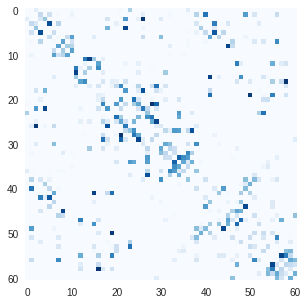

In [12]:
mtx = get_mtx(mrf,msa_idx)  
plot_mtx(mtx)

## Look at top co-evolving residue pairs

In [0]:
# load mtx into pandas dataframe
pd_mtx = pd.DataFrame(mtx,columns=["i","j","zscore"])

In [14]:
# get contacts with sequence seperation > 5
# sort by zscore, show top 10
top = pd_mtx.loc[pd_mtx['j'] - pd_mtx['i'] > 5].sort_values("zscore",ascending=False)
top.head(10)

,i,j,zscore
1056,21,28,2.974916
881,16,58,2.960092
142,2,26,2.941696
999,19,50,2.922103
820,15,41,2.858699
488,8,45,2.820720
251,4,22,2.814801
1278,27,37,2.748682
934,18,26,2.732130
326,5,42,2.693025


## Explore the MRF

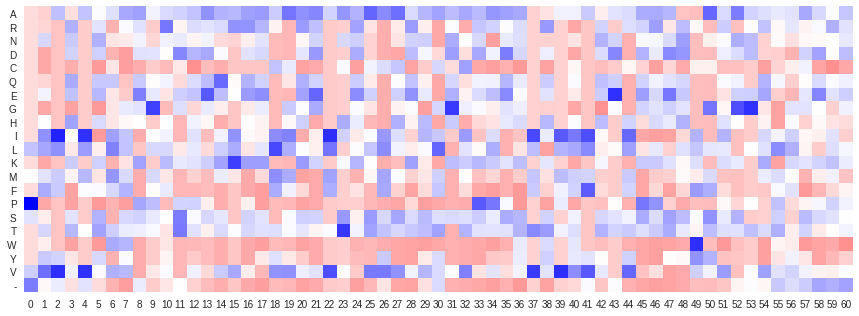

In [15]:
def plot_v(mrf,idx=None):
  
  # if no index provide, use indices from input mrf
  if idx is None:
    idx = np.arange(0,mrf["v"].shape[0])
  
  al_a = list(alphabet)
  v = mrf["v"].T
  mx = np.max((v.max(),np.abs(v.min())))
  plt.figure(figsize=(v.shape[1]/4,states/4))
  plt.imshow(-v,cmap='bwr',vmin=-mx,vmax=mx)
  plt.xticks(np.arange(v.shape[1]))
  plt.yticks(np.arange(0,21))
  plt.grid(False)
  ax = plt.gca()
  ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: idx[x])) 
  ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: al_a[x]))
  
plot_v(mrf,msa_idx)

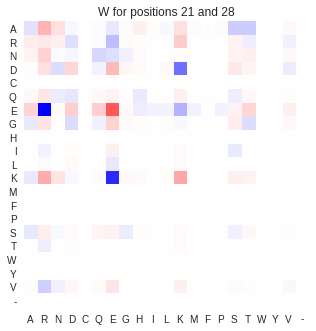

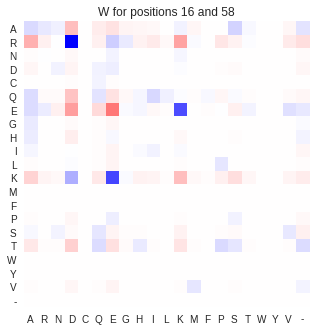

In [16]:
def plot_w(mrf,i,j,idx=None):
  # if no index provide, use indices from input mrf
  if idx is None:
    idx = np.arange(0,mrf["v"].shape[0])
    
  al_a = list(alphabet)
  
  ref = {}
  for n,m in zip(idx,range(idx.shape[0])):
    ref[n] = m
  
  w = mrf["w"][ref[i],:,ref[j],:]
  mx = np.max((w.max(),np.abs(w.min())))
  plt.figure(figsize=(states/4,states/4))
  plt.imshow(-w,cmap='bwr',vmin=-mx,vmax=mx)
  plt.xticks(np.arange(0,states))
  plt.yticks(np.arange(0,states))
  plt.grid(False)
  ax = plt.gca()
  ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: al_a[x])) 
  ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: al_a[x]))
  plt.title(f"W for positions {i} and {j}")
  plt.show()

for n in range(2):
  i = int(top.iloc[n]["i"])
  j = int(top.iloc[n]["j"])
  plot_w(mrf,i,j,msa_idx)

## validating output
(comparing to known output from GREMLIN_cpp version)

In [0]:
!wget -q -nc http://files.ipd.uw.edu/krypton/4FAZA.out

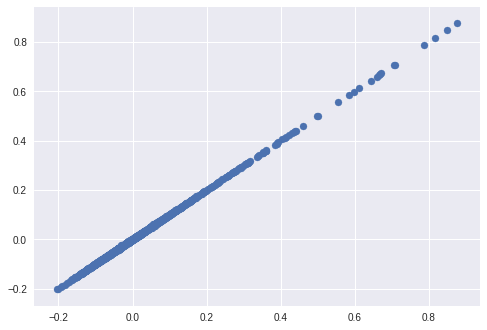

In [18]:
pd_test = pd.read_table("4FAZA.out",sep=" ")
plt.scatter(pd_test["apc"],mtx["apc"])
plt.show()

### Input to NN (Neural Networks)

The "apc" values are typically used as input to the NN for contact cleaning or structure prediction. Though in recent advances (aka DeepMind/Alphafold), the entire MRF was used as the input. More specificially LxLx442. The 442 channels are the 21x21 + (raw and/or apc) value.

In [20]:
# transpose to (L,L,21,21)
mrf_tmp = np.transpose(mrf["w"],(0,2,1,3))

# triu to ((L*(L-1)/2),21,21) since symmetric
mrf_idx = np.triu_indices(len(mrf_tmp),k=1)
mrf_tmp = mrf_tmp[mrf_idx]

# reshape to (-1,441)
mrf_tmp = np.reshape(mrf_tmp,(-1,441))

# add apc channel
apc_tmp = np.expand_dims(mtx["apc"],-1)
mrf_tmp = np.concatenate((mrf_tmp,apc_tmp),-1)

# fill in missing positions (due to gap removal) with zeros
idx = (msa_idx[mrf_idx[0]],msa_idx[mrf_idx[1]])
len_full = len(seqs[0])
mrf_full = np.zeros((len_full,len_full,442))
mrf_full[idx] = mrf_tmp
mrf_full += np.transpose(mrf_full,(1,0,2))

print(mrf_full.shape)

(62, 62, 442)


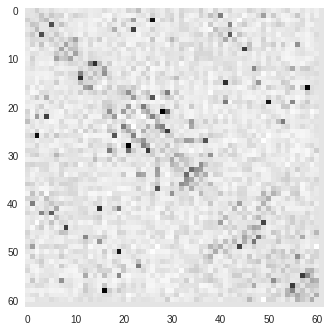

In [22]:
plt.imshow(mrf_full[:,:,-1])
plt.grid(False)
plt.show()